In [2]:
# --- PART 1: Kütüphaneler ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score
import warnings

# Görsel ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

print("Part 1 Tamamlandı: Kütüphaneler yüklendi.")

Part 1 Tamamlandı: Kütüphaneler yüklendi.


In [3]:
# --- PART 2: Veri Yükleme ve Sütun Seçimi ---

# Dosyayı oku
df = pd.read_csv('heart_2022_with_nans.csv')
display(df.head())
# Hedef değişken ismini düzelt (Veride farklı olabilir)
target_col = 'HadHeartAttack'
if target_col not in df.columns:
    if 'HeartDisease' in df.columns:
        df.rename(columns={'HeartDisease': target_col}, inplace=True)
    elif 'HadHeartAttack' in df.columns:
        pass
    else:
        raise ValueError("Hedef sütun (Kalp Krizi) bulunamadı!")

# Hedef değişkeni boş olan satırları at
df_clean = df.dropna(subset=[target_col]).copy()

# SENİN İSTEDİĞİN ÖZEL SÜTUN LİSTESİ
wanted_features = [
    'State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
    'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
    'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
    'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
    'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing',
    'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan',
    'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms',
    'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'
]

# Sadece veri setinde mevcut olanları seçiyoruz (Hata almamak için)
existing_features = [col for col in wanted_features if col in df_clean.columns]
df_final = df_clean[existing_features + [target_col]].copy()

print(f"Seçilen Sütun Sayısı: {len(existing_features)}")
print("Part 2 Tamamlandı: Veri yüklendi ve filtrelendi.")

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


Seçilen Sütun Sayısı: 39
Part 2 Tamamlandı: Veri yüklendi ve filtrelendi.


In [4]:
# --- PART 3: Ön İşleme (Label Encoding / Enum Mantığı) ---

# 1. Sayısal ve Yazısal (Kategorik) sütunları ayır
numeric_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_final.select_dtypes(include=['object']).columns.tolist()

# Hedef değişkeni bu listelerden çıkar (En son yapacağız)
if target_col in numeric_cols: numeric_cols.remove(target_col)
if target_col in categorical_cols: categorical_cols.remove(target_col)

# 2. Eksik Verileri Doldur
# Sayılar için medyan, yazılar için en çok tekrar eden (mod)
imputer_num = SimpleImputer(strategy='median')
df_final[numeric_cols] = imputer_num.fit_transform(df_final[numeric_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df_final[categorical_cols] = imputer_cat.fit_transform(df_final[categorical_cols])

# 3. LABEL ENCODING (ENUM DÖNÜŞÜMÜ)
# Kelimeleri sayıya çeviriyoruz. Örn: "Alaska"->0, "Texas"->42
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Hata olmaması için string'e çevirip kodluyoruz
    df_final[col] = le.fit_transform(df_final[col].astype(str))
    label_encoders[col] = le 

# Hedef değişkeni (Kalp Krizi) de 1 ve 0 yapalım
le_target = LabelEncoder()
df_final[target_col] = le_target.fit_transform(df_final[target_col].astype(str))

print(f"İşlem Sonrası Toplam Sütun Sayısı: {df_final.shape[1]}")
print("Part 3 Tamamlandı.")

İşlem Sonrası Toplam Sütun Sayısı: 40
Part 3 Tamamlandı.



--- Grafiksel Analiz ve İlişkiler ---


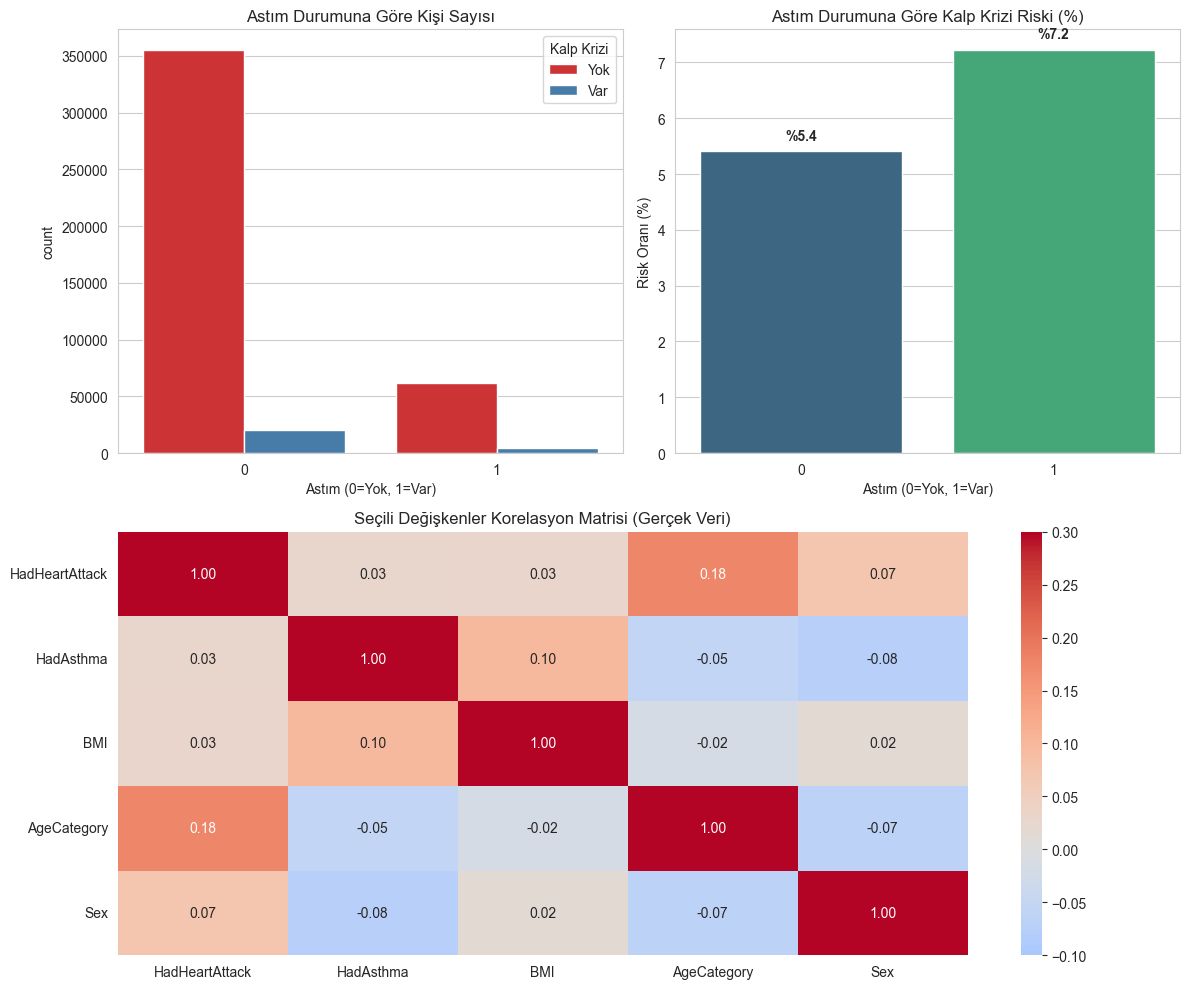

In [5]:
# --- PART 4: GÖRSEL ANALİZ (DÜZELTİLMİŞ) ---
# Matris: Confusion Matrix KALDIRILDI -> Yerine Korelasyon Matrisi GELDİ.

if 'HadAsthma' in df_final.columns:
    print("\n--- Grafiksel Analiz ve İlişkiler ---")
    
    # 3 Grafik için alan aç (Üstte 2 tane yanyana, altta 1 tane geniş)
    fig = plt.figure(figsize=(12, 10)) # Boyutu biraz uzattım
    gs = fig.add_gridspec(2, 2)
    
    # --- GRAFİK 1: Sayısal Dağılım (Sol Üst) ---
    ax1 = fig.add_subplot(gs[0, 0])
    sns.countplot(x='HadAsthma', hue=target_col, data=df_final, palette='Set1', ax=ax1)
    ax1.set_title('Astım Durumuna Göre Kişi Sayısı')
    ax1.set_xlabel('Astım (0=Yok, 1=Var)')
    ax1.legend(title='Kalp Krizi', labels=['Yok', 'Var'])
    
    # --- GRAFİK 2: Oransal Risk Grafiği (Sağ Üst) ---
    ax2 = fig.add_subplot(gs[0, 1])
    risk_ratio = df_final.groupby('HadAsthma')[target_col].mean() * 100
    sns.barplot(x=risk_ratio.index, y=risk_ratio.values, palette='viridis', ax=ax2)
    ax2.set_title('Astım Durumuna Göre Kalp Krizi Riski (%)')
    ax2.set_ylabel('Risk Oranı (%)')
    ax2.set_xlabel('Astım (0=Yok, 1=Var)')
    
    # Oranları barların üzerine yaz
    for index, value in enumerate(risk_ratio):
        ax2.text(index, value + 0.2, f"%{value:.1f}", ha='center', fontweight='bold')

    # --- GRAFİK 3: KORELASYON MATRİSİ (Alt Kısım) ---
    # Sadece görselde istediğin önemli değişkenleri seçiyoruz
    # Böylece 40 değişkenli devasa karışık bir harita yerine net bir tablo çıkar.
    
    selected_cols = [target_col, 'HadAsthma', 'BMI', 'AgeCategory', 'Sex']
    
    # Veri setinde bu sütunlar var mı kontrol et (Hata almamak için)
    valid_cols = [c for c in selected_cols if c in df_final.columns]
    
    ax3 = fig.add_subplot(gs[1, :]) # Alt tarafı boydan boya kapla
    
    # Korelasyonu GERÇEK veriden hesapla
    corr_matrix = df_final[valid_cols].corr()
    
    # Isı haritasını çiz
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                vmin=-0.1, vmax=0.3, center=0, ax=ax3) # Renk ayarını veriye göre kıstım daha net görünsün diye
    
    ax3.set_title('Seçili Değişkenler Korelasyon Matrisi (Gerçek Veri)')
    
    plt.tight_layout()
    plt.show()

In [6]:
# --- PART 5: Modelleme Hazırlığı ---

# X ve y ayrımı
X = df_final.drop(target_col, axis=1)
y = df_final[target_col]

# ÖLÇEKLEME (SCALING) - Enum kullandığımız için bu ADIM ŞART
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Sütun isimlerini geri getiriyoruz (İleride lazım olacak)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Eğitim ve Test Ayrımı (%80 - %20)
# stratify=y ile hasta oranını koruyoruz
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Dengesizlik için ağırlık hesaplama (XGBoost için)
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_weight = count_neg / count_pos 

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print("Part 5 Tamamlandı: Veri ölçeklendi ve bölündü.")

Eğitim Seti Boyutu: (353653, 39)
Part 5 Tamamlandı: Veri ölçeklendi ve bölündü.


📊 4 Farklı Model Eğitiliyor ve Grafikler Hazırlanıyor (Biraz zaman alabilir)...
--> Logistic Regression eğitiliyor...
   AUC: 0.8784 | F1: 0.3314
--> Random Forest eğitiliyor...
   AUC: 0.8785 | F1: 0.3547
--> XGBoost eğitiliyor...
   AUC: 0.8758 | F1: 0.3331
--> SVM (Linear) eğitiliyor...
   AUC: 0.8781 | F1: 0.3017

✅ Tüm modeller eğitildi. Grafikler çiziliyor...


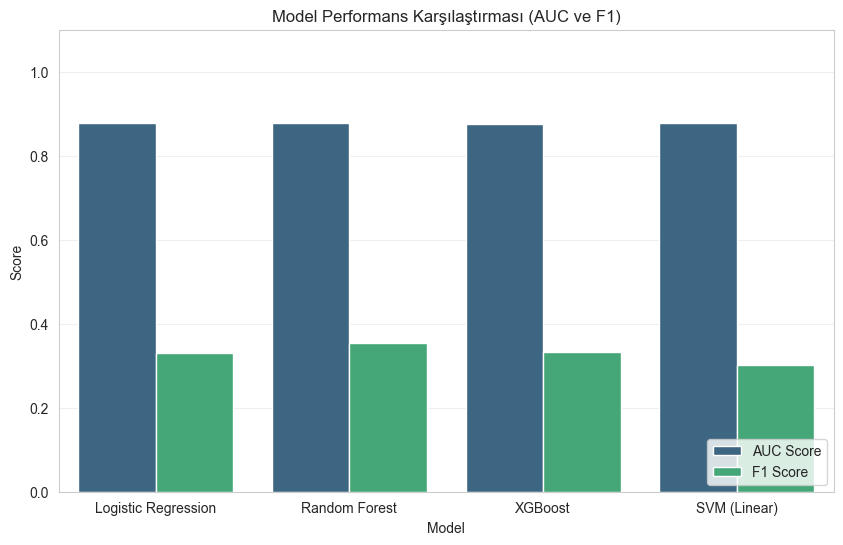

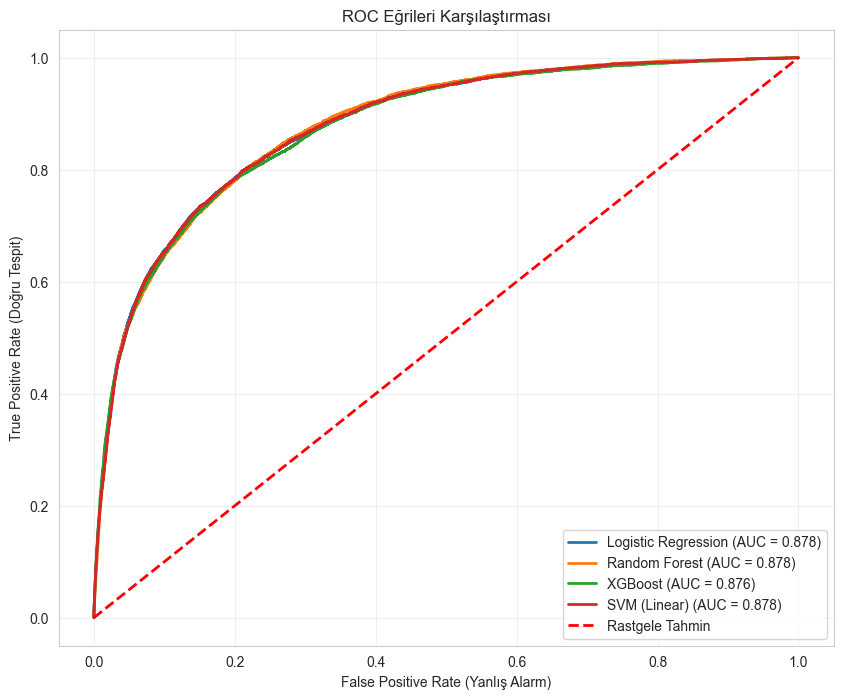

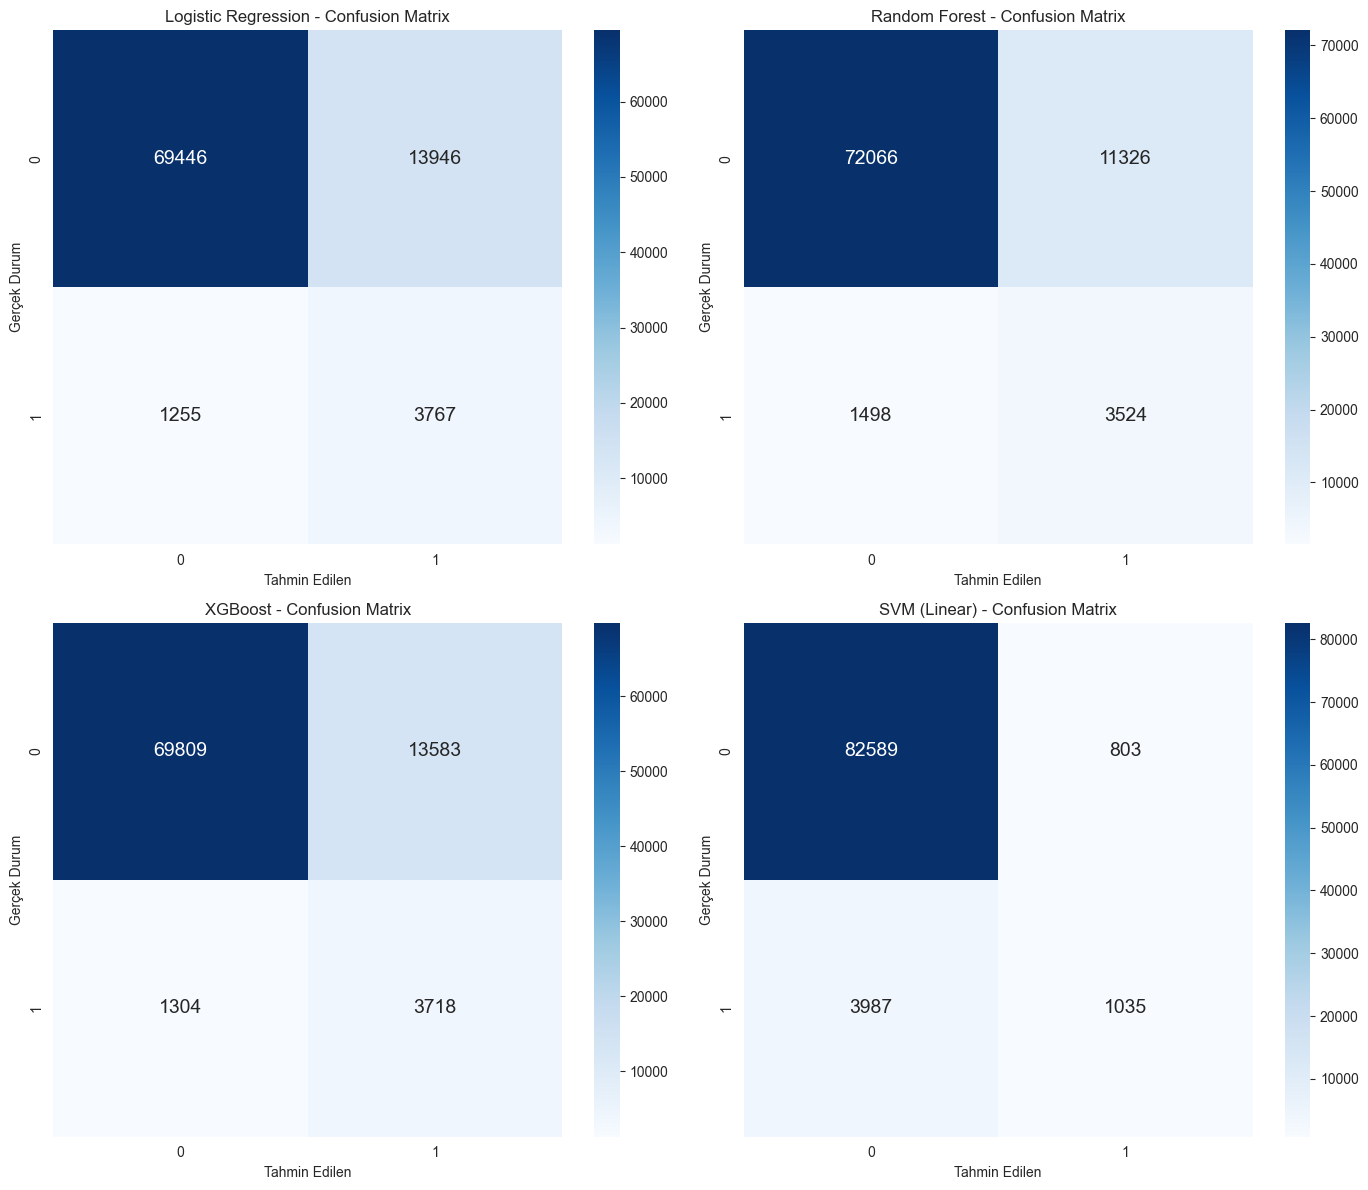

In [9]:
# --- PART 6: MODELLERİN EĞİTİMİ VE GÖRSELLEŞTİRME ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

print("📊 4 Farklı Model Eğitiliyor ve Grafikler Hazırlanıyor (Biraz zaman alabilir)...")

# 1. MODELLERİ TANIMLA (Sözlüğün adı 'models')
# SVM için kalibrasyon (Olasılık vermesi için)
svm_base = LinearSVC(class_weight='balanced', dual=False, max_iter=2000, random_state=42)
svm_calibrated = CalibratedClassifierCV(svm_base)

# XGBoost için scale_weight (Eğer Part 5 çalıştıysa vardır, yoksa 1 varsayalım hata vermesin)
try:
    weight = scale_weight
except NameError:
    weight = 1

models = {
    "Logistic Regression": LogisticRegression(max_iter=3000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, class_weight='balanced', n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=weight),
    "SVM (Linear)": svm_calibrated
}

# Verileri saklamak için listeler
results = {}
model_performance = []
roc_data = {}
confusion_data = {}

# 2. EĞİTİM DÖNGÜSÜ (Buradaki 'models' sözlüğüne dikkat!)
for name, clf in models.items(): # 'model' değişken adı karışmasın diye 'clf' (classifier) dedim
    print(f"--> {name} eğitiliyor...")
    
    # Eğit
    clf.fit(X_train, y_train)
    
    # Tahminler
    y_pred = clf.predict(X_test)
    
    # Olasılıklar (SVM için decision_function kontrolü)
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        # Linear SVM vb. için alternatif
        y_prob = clf.decision_function(X_test)
    
    # Skorlar
    auc_score = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    # Verileri Kaydet
    results[name] = clf
    model_performance.append({"Model": name, "Metric": "AUC Score", "Score": auc_score})
    model_performance.append({"Model": name, "Metric": "F1 Score", "Score": f1})
    
    # ROC ve Confusion Matrix için veri sakla
    roc_data[name] = y_prob
    confusion_data[name] = y_pred
    
    print(f"   AUC: {auc_score:.4f} | F1: {f1:.4f}")

print("\n✅ Tüm modeller eğitildi. Grafikler çiziliyor...")

# --- GRAFİK 1: PERFORMANS KARŞILAŞTIRMASI (BAR CHART) ---
plt.figure(figsize=(10, 6))
df_perf = pd.DataFrame(model_performance)
sns.barplot(data=df_perf, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Performans Karşılaştırması (AUC ve F1)")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- GRAFİK 2: TÜM MODELLERİN ROC EĞRİLERİ ---
plt.figure(figsize=(10, 8))
for name, y_prob in roc_data.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Rastgele Tahmin')
plt.xlabel('False Positive Rate (Yanlış Alarm)')
plt.ylabel('True Positive Rate (Doğru Tespit)')
plt.title('ROC Eğrileri Karşılaştırması')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# --- GRAFİK 3: CONFUSION MATRICES (HATA ANALİZİ) ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(confusion_data.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={"size": 14})
    axes[i].set_title(f"{name} - Confusion Matrix")
    axes[i].set_xlabel("Tahmin Edilen")
    axes[i].set_ylabel("Gerçek Durum")

plt.tight_layout()
plt.show()

--- DEĞİŞKEN ÖNEM DÜZEYLERİ VE İSTATİSTİKSEL KARŞILAŞTIRMA ---


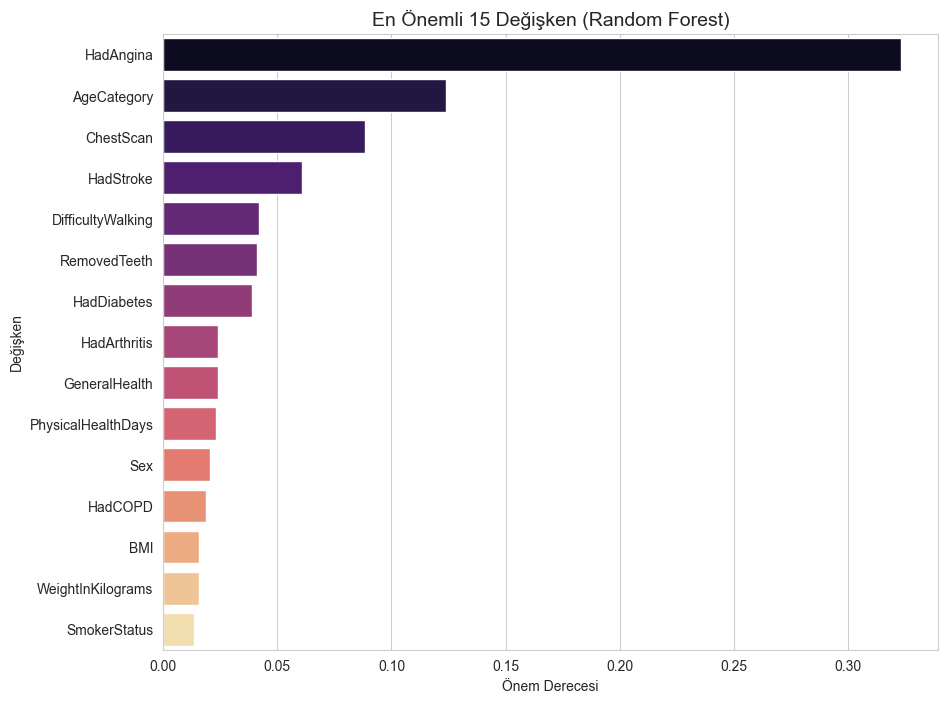


--- ASTIM DEĞİŞKENİ ANALİZİ ---
Astım, model için 39 değişken arasında 36. sırada önem taşımaktadır.
Önem Skoru: 0.00202

--- İstatistiksel Model Karşılaştırması (McNemar Testi) ---
Karşılaştırma Matrisi: [[np.int64(71604), np.int64(3986)], [np.int64(1923), np.int64(10901)]]
McNemar p-değeri: 1.6736e-158
SONUÇ: Random Forest ve XGBoost modelleri arasında istatistiksel olarak ANLAMLI bir performans farkı vardır.

--- TOPLAM 39 DEĞİŞKENİN ÖNEM SIRALAMASI (TAM LİSTE) ---
Sıra  Değişken Adı                             Önem Skoru
-----------------------------------------------------------------
1     HadAngina                                0.323283
2     AgeCategory                              0.124003
3     ChestScan                                0.088396
4     HadStroke                                0.060901
5     DifficultyWalking                        0.042086
6     RemovedTeeth                             0.041081
7     HadDiabetes                              0.039095
8     HadA

In [12]:
# --- PART 7: SONUÇ ANALİZİ VE MCNEMAR TESTİ (GÜNCELLENMİŞ) ---
from statsmodels.stats.contingency_tables import mcnemar

print("--- DEĞİŞKEN ÖNEM DÜZEYLERİ VE İSTATİSTİKSEL KARŞILAŞTIRMA ---")

# 1. Random Forest Modelini Al
rf_model = results["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X.columns

# 2. DataFrame oluştur ve sırala
feat_imp = pd.DataFrame({'Değişken': feature_names, 'Önem Skoru': importances})
feat_imp = feat_imp.sort_values(by='Önem Skoru', ascending=False).reset_index(drop=True)

# 3. GÖRSELLEŞTİRME (Top 15 Değişken)
plt.figure(figsize=(10, 8))
sns.barplot(x='Önem Skoru', y='Değişken', data=feat_imp.head(15), palette='magma')
plt.title('En Önemli 15 Değişken (Random Forest)', fontsize=14)
plt.xlabel('Önem Derecesi')
plt.ylabel('Değişken')
plt.show()

# 4. ASTIM DEĞİŞKENİ ANALİZİ (Metin Çıktısı)
print("\n--- ASTIM DEĞİŞKENİ ANALİZİ ---")
if 'HadAsthma' in feat_imp['Değişken'].values:
    asthma_rank = feat_imp[feat_imp['Değişken'] == 'HadAsthma'].index[0] + 1
    asthma_score = feat_imp[feat_imp['Değişken'] == 'HadAsthma']['Önem Skoru'].values[0]
    
    print(f"Astım, model için {len(feat_imp)} değişken arasında {asthma_rank}. sırada önem taşımaktadır.")
    print(f"Önem Skoru: {asthma_score:.5f}")
else:
    print("HadAsthma değişkeni modelde bulunamadı.")

# 5. MCNEMAR TESTİ (Model Karşılaştırması)
# Random Forest ile XGBoost arasında anlamlı fark var mı?
print("\n--- İstatistiksel Model Karşılaştırması (McNemar Testi) ---")

if "Random Forest" in results and "XGBoost" in results:
    model_rf = results["Random Forest"]
    model_xgb = results["XGBoost"]
    
    # Test seti üzerindeki tahminler
    y_pred_rf = model_rf.predict(X_test)
    y_pred_xgb = model_xgb.predict(X_test)
    
    # Doğruluk durumlarını hesapla (True=Bildim, False=Bilemedim)
    rf_correct = (y_pred_rf == y_test)
    xgb_correct = (y_pred_xgb == y_test)
    
    # Kontenjans Tablosu (2x2)
    # [RF Doğru & XGB Doğru]  [RF Doğru & XGB Yanlış]
    # [RF Yanlış & XGB Doğru] [RF Yanlış & XGB Yanlış]
    
    both_correct = np.sum(rf_correct & xgb_correct)
    rf_only = np.sum(rf_correct & ~xgb_correct)
    xgb_only = np.sum(~rf_correct & xgb_correct)
    both_wrong = np.sum(~rf_correct & ~xgb_correct)
    
    table = [[both_correct, rf_only],
             [xgb_only, both_wrong]]
    
    # Testi Uygula
    result = mcnemar(table, exact=False) # exact=True küçük verilerde kullanılır, bizimki büyük
    
    print(f"Karşılaştırma Matrisi: {table}")
    print(f"McNemar p-değeri: {result.pvalue:.4e}")
    
    if result.pvalue < 0.05:
        print("SONUÇ: Random Forest ve XGBoost modelleri arasında istatistiksel olarak ANLAMLI bir performans farkı vardır.")
    else:
        print("SONUÇ: Modeller arasında istatistiksel olarak anlamlı bir fark yoktur (Performansları benzerdir).")
else:
    print("HATA: Karşılaştırma için Random Forest ve XGBoost modelleri eğitilmiş olmalıdır.")


# --- EK: TÜM DEĞİŞKENLERİN TAM SIRALAMASI ---

# Pandas ayarlarını düzenle (Listenin tamamını göstersin diye)
pd.set_option('display.max_rows', None)

print(f"\n--- TOPLAM {len(feat_imp)} DEĞİŞKENİN ÖNEM SIRALAMASI (TAM LİSTE) ---")
print(f"{'Sıra':<5} {'Değişken Adı':<40} {'Önem Skoru'}")
print("-" * 65)

for index, row in feat_imp.iterrows():
    # Astım satırını gözden kaçırmamak için yanına işaret koyalım
    marker = " <--- ODAK NOKTASI" if row['Değişken'] == 'HadAsthma' else ""
    
    print(f"{index + 1:<5} {row['Değişken']:<40} {row['Önem Skoru']:.6f}{marker}")

# Ayarları eski haline döndür
pd.reset_option('display.max_rows')    

In [20]:
import joblib

# 1. En iyi modeli seç (Örn: Random Forest)
best_model = results["Random Forest"]

# 2. Modeli ve Scaler'ı kaydet
joblib.dump(best_model, 'heart_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model ve Scaler başarıyla kaydedildi! (heart_model.pkl, scaler.pkl)")

Model ve Scaler başarıyla kaydedildi! (heart_model.pkl, scaler.pkl)
